In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import simweights
import pickle
import os, sys
import re
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import pandas as pd
import tables
import h5py
import math
from scipy.stats import mstats
import matplotlib as mpl
import matplotlib.font_manager as font_manager


In [4]:
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing/notebooks/weighting")
from weights import *
from utils import *
from selections import selection_mask
from fonts import *
from plot_utils import *

In [5]:
# Append the custom module path
sys.path.append("/data/user/tvaneede/GlobalFit/reco_processing")

# Import the datasets module
from datasets import datasets

# set the inputs
reco_versions = ["evtgen_v4_rec_v9", "spice_tau_reco"]

# Dynamically select the desired dataset
simulation_datasets = {}
for reco_version in reco_versions: simulation_datasets[reco_version] = getattr(datasets, reco_version)

In [7]:
livetime_yr = 11.687
livetime_s  = livetime_yr * 365.25 * 24 * 3600 # 11.687 year

In [8]:
plotting_path = f"/data/user/tvaneede/GlobalFit/reco_processing/notebooks/compare_spice_ftp/compare_true_var_tianlu_neha"
os.system(f"mkdir -p {plotting_path}")

0

In [9]:
# weight functions
spline_file = '/data/ana/Diffuse/NNMFit/MCEq_splines/v1.2.1/MCEq_splines_PRI-Gaisser-H4a_INT-SIBYLL23c_allfluxes.pickle'

# conventional            
flux_keys_conv =  ['conv_antinumu','conv_numu','conv_antinue','conv_nue','conv_antinutau','conv_nutau']
spline_object_conv = SplineHandler(spline_file, flux_keys_conv)
conv_flux = spline_object_conv.return_weight
generator_conv = lambda pdgid, energy, cos_zen: conv_flux(pdgid, energy, cos_zen)

# prompt
flux_keys_pr =  ['pr_antinumu','pr_numu','pr_antinue','pr_nue','pr_antinutau','pr_nutau']
spline_object_pr = SplineHandler(spline_file, flux_keys_pr)
pr_flux = spline_object_pr.return_weight
generator_pr = lambda pdgid, energy, cos_zen: pr_flux(pdgid, energy, cos_zen)

# astro
gamma_astro = 2.87
per_flavor_norm = 2.12
def AstroFluxModel(pdgid, energy, cos_zen):
    flux = 0.5*(per_flavor_norm*1e-18)*(energy/1e5)**-gamma_astro
    return flux

In [10]:
def open_datasets( simulation_dataset, keys_to_merge ):

    # open the files
    for key in simulation_dataset:
        print(f"----- Extracting files for {key}")
        simulation_dataset[key]['hdf_file'] = pd.HDFStore(simulation_dataset[key]['hdf_file_path'],'r')
        simulation_dataset[key]['weighter'] = simweights.NuGenWeighter( simulation_dataset[key]['hdf_file'] ,nfiles=simulation_dataset[key]['nfiles'])

    # merging files
    for new_key in keys_to_merge:
        print(f"----- Creating new key {new_key}")
        simulation_dataset[new_key] = {}
        simulation_dataset[new_key]['variables'] = {}
        simulation_dataset[new_key]['weighter'] = None

        for key in keys_to_merge[new_key]:
            
            print(f"Using {key}")
            # merge the weighters
            if simulation_dataset[new_key]['weighter'] == None:
                simulation_dataset[new_key]['weighter'] = simulation_dataset[key]['weighter']
            else: simulation_dataset[new_key]['weighter'] += simulation_dataset[key]['weighter']

    # calculate weights
    for key in simulation_dataset:
        simulation_dataset[key]['weights_astro'] = simulation_dataset[key]["weighter"].get_weights(AstroFluxModel) * livetime_s
        simulation_dataset[key]['weights_conv'] = simulation_dataset[key]["weighter"].get_weights(generator_conv) * livetime_s
        simulation_dataset[key]['weights_pr'] = simulation_dataset[key]["weighter"].get_weights(generator_pr) * livetime_s


    return simulation_dataset



In [11]:
keys_to_merge = {}

keys_to_merge["evtgen_v4_rec_v9"] = {
    "NuE" : ["NuE_midE", "NuE_highE"],
    "NuMu" : ["NuMu_midE", "NuMu_highE"],
    "NuTau" : ["NuTau_midE", "NuTau_highE"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],
}

keys_to_merge["spice_tau_reco"] = {
    "NuE" : ["NuE_midE1", "NuE_highE1", "NuE_midE2", "NuE_highE2"],
    "NuMu" : ["NuMu_midE1", "NuMu_highE1","NuMu_midE2", "NuMu_highE2"],
    "NuTau" : ["NuTau_midE1", "NuTau_highE1","NuTau_midE2", "NuTau_highE2"],
    "NuAll" : ['NuE', "NuMu", "NuTau"],

}

In [12]:
for key in simulation_datasets: simulation_datasets[key] = open_datasets( simulation_datasets[key], keys_to_merge[key] )

----- Extracting files for NuTau_midE
----- Extracting files for NuTau_highE
----- Extracting files for NuE_midE
----- Extracting files for NuE_highE
----- Extracting files for NuMu_midE
----- Extracting files for NuMu_highE
----- Creating new key NuE
Using NuE_midE
Using NuE_highE
----- Creating new key NuMu
Using NuMu_midE
Using NuMu_highE
----- Creating new key NuTau
Using NuTau_midE
Using NuTau_highE
----- Creating new key NuAll
Using NuE
Using NuMu
Using NuTau
----- Extracting files for NuTau_midE1
----- Extracting files for NuTau_highE1
----- Extracting files for NuTau_midE2
----- Extracting files for NuTau_highE2
----- Extracting files for NuE_midE1
----- Extracting files for NuE_highE1
----- Extracting files for NuE_midE2
----- Extracting files for NuE_highE2
----- Extracting files for NuMu_midE1
----- Extracting files for NuMu_highE1
----- Extracting files for NuMu_midE2
----- Extracting files for NuMu_highE2
----- Creating new key NuE
Using NuE_midE1
Using NuE_highE1
Using Nu

In [13]:
dataset_label_dict = {
    "evtgen_v4_rec_v9" : "ftp-v3",
    "spice_tau_reco" : "spice v3.2.1",
}

check if merging works now, seems to be fine

/tmp/ipykernel_54626/4104227861.py:55: RuntimeWarning: invalid value encountered in divide
  ratio = hist1 / hist2


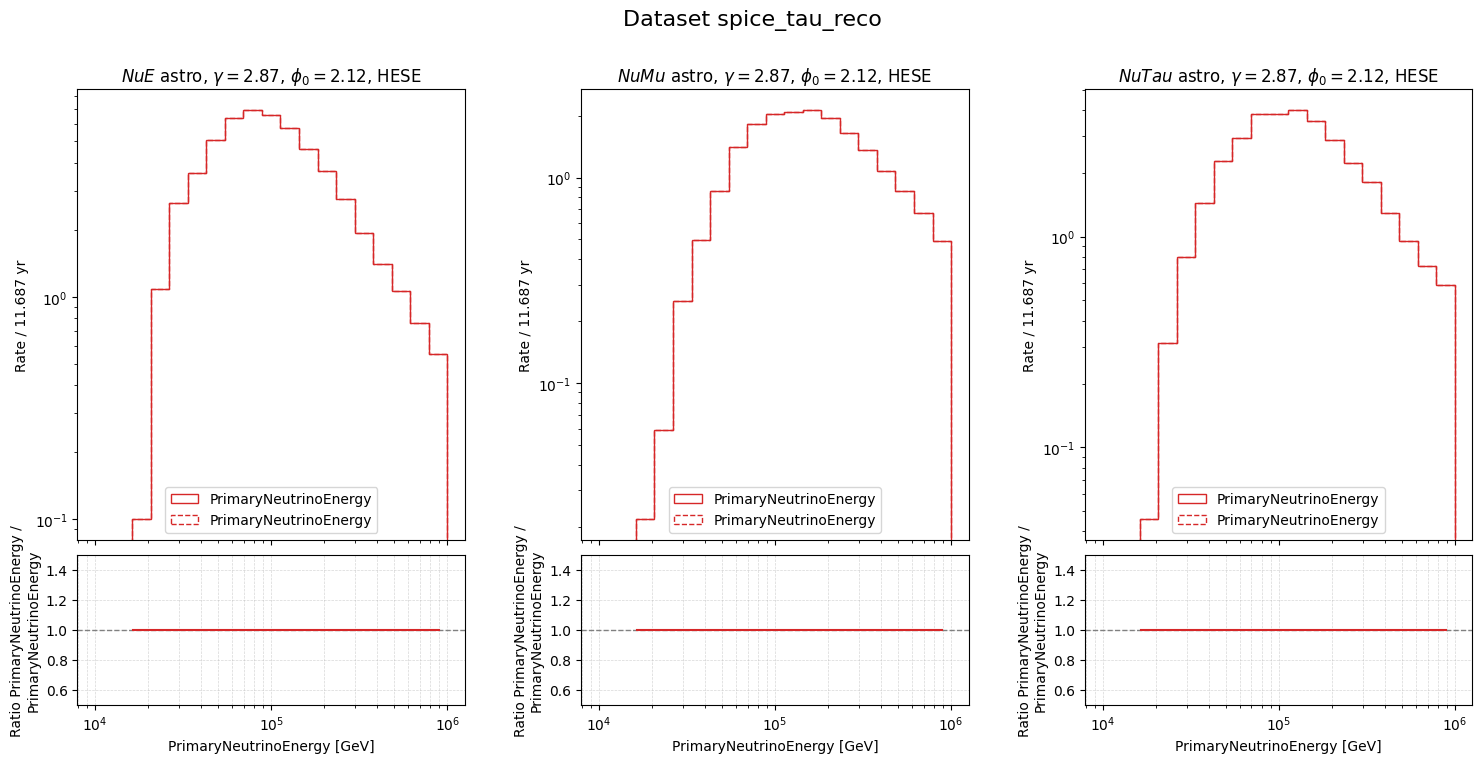

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D

colors = ["black", "C3", "C2", "C1"]
 
def compare_ice_model( dataset_key = "spice_tau_reco",
                       var1_key1 = "I3MCWeightDict", 
                       var1_key2 = "PrimaryNeutrinoEnergy",
                       var1_name = "PrimaryNeutrinoEnergy",
                       var2_key1 = "I3MCWeightDict", 
                       var2_key2 = "PrimaryNeutrinoEnergy",
                       var2_name = "PrimaryNeutrinoEnergy",
                       xlabel    = "PrimaryNeutrinoEnergy [GeV]",
                       bins = np.geomspace(1e4, 1e6, 20),
                       xscale = "log", yscale = "log",
                       savename = "PrimaryNeutrinoEnergy.pdf"):

    color = "C3"

    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
    fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
    gs = GridSpec(2, 3, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

    fig.suptitle(rf"Dataset {dataset_key}", fontsize=16)

    # Create 3 upper and 3 lower subplots
    axes = [fig.add_subplot(gs[0, i]) for i in range(3)]        # ax0, ax1, ax2
    axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(3)]  # ax0_ratio, etc.

    # Now iterate over axes
    for ax, ax_ratio, flavor in zip(axes, axes_ratio, ["NuE", "NuMu", "NuTau"]):
        ax.set_title(rf"${flavor}$ astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE")
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_ylabel(f"Rate / {livetime_yr} yr") 

        ax_ratio.set_xscale(xscale)
        ax_ratio.set_ylabel(f"Ratio {var1_name} /\n{var2_name}")
        ax_ratio.set_xlabel(xlabel)
        ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

        var1 = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var1_key1, var1_key2)
        var2 = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var2_key1, var2_key2)

        # Compute histograms
        hist1, _  = np.histogram(var1,weights=simulation_datasets[dataset_key][flavor]["weights_astro"],bins=bins )
        hist2, _  = np.histogram(var2,weights=simulation_datasets[dataset_key][flavor]["weights_astro"],bins=bins )

        # Compute ratios
        ratio = hist1 / hist2

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color=color)

        # Upper plot: histograms
        ax.hist(var1, 
                weights=simulation_datasets[dataset_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", color=color, linestyle="-",label = var1_name)
        ax.hist(var2, 
                weights=simulation_datasets[dataset_key][flavor]["weights_astro"], 
                bins=bins, histtype="step", color=color, linestyle="--",label = var2_name)


        # Improve layout
        plt.setp(ax.get_xticklabels(), visible=False)
        ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
        ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

        ax.legend()

    plt.savefig(f"{plotting_path}/{savename}")

    plt.show()

# test
compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "I3MCWeightDict", 
                    var1_key2 = "PrimaryNeutrinoEnergy",
                    var1_name = "PrimaryNeutrinoEnergy",
                    var2_key1 = "I3MCWeightDict", 
                    var2_key2 = "PrimaryNeutrinoEnergy",
                    var2_name = "PrimaryNeutrinoEnergy",
                    bins = np.geomspace(1e4, 1e6, 20),
                    xlabel="PrimaryNeutrinoEnergy [GeV]",
                    xscale = "log", yscale = "log",
                    savename = "PrimaryNeutrinoEnergy.pdf" )



Let's start with the true energy.

Neha calculates in MCPreProc.py addtrueenergydepositions the total energy of all particles etot. The truncated energy is only for particles inside the innerboundary, outeredge_x and y. These are stored in
- MCTrueDepositedEnergy
- MCTrueTruncatedDepositedEnergy
Aparantly I havent stored these yet, but there is TrueETot, which always stores MCTrueTruncatedDepositedEnergy except for energies below 1 TeV

Tianlu creates the cc object in truth.py truth where for hypothesis cascade the get_most_energetic_inice_cascade is used. For tau it finds the tau lepton. Then it uses a library.get_deposit_energy function.

Let's compare TrueETot with cc.energy.

The results are very similar, except for NuMu where Neha is higher at low energy, and lower at high energy than Tianlu. It has to be said the cc was obtained using the tau hypothesis, so its not supposed to work there. Furthermore, at low energy NuTau, Neha has less events because of the 1 TeV energy threshold (I think?). Next hdf5 iteration I include MCTrueDepositedEnergy MCTrueTruncatedDepositedEnergy

/tmp/ipykernel_14654/4104227861.py:55: RuntimeWarning: invalid value encountered in divide
  ratio = hist1 / hist2
/tmp/ipykernel_14654/4104227861.py:55: RuntimeWarning: divide by zero encountered in divide
  ratio = hist1 / hist2


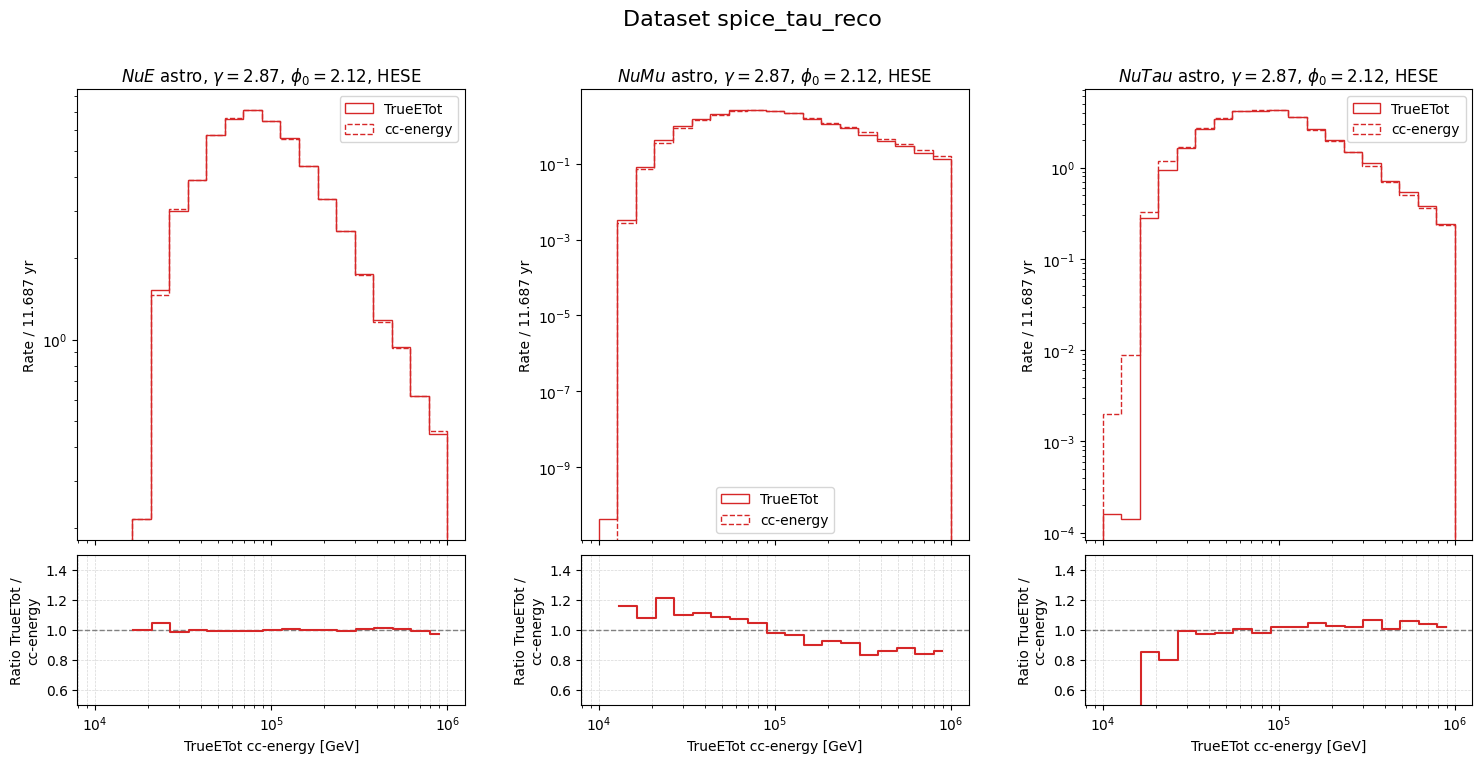

In [15]:
compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueETot", 
                    var1_key2 = "value",
                    var1_name = "TrueETot",
                    var2_key1 = "cc", 
                    var2_key2 = "energy",
                    var2_name = "cc-energy",
                    bins = np.geomspace(1e4, 1e6, 20),
                    xlabel="TrueETot cc-energy [GeV]",
                    xscale = "log", yscale = "log",
                    savename = "TrueETot_vs_cc-energy.pdf" )

Now let's do the direction, from Neha we have
- TrueZenith
- TrueAzimuth
which is the direction of the 1st cascade from MCInteractionDoubleBang, which is VertexOutgoingHadron for true double cascades.

From Tianlu, we have cc-zenith and azimuth. This all matches very well.

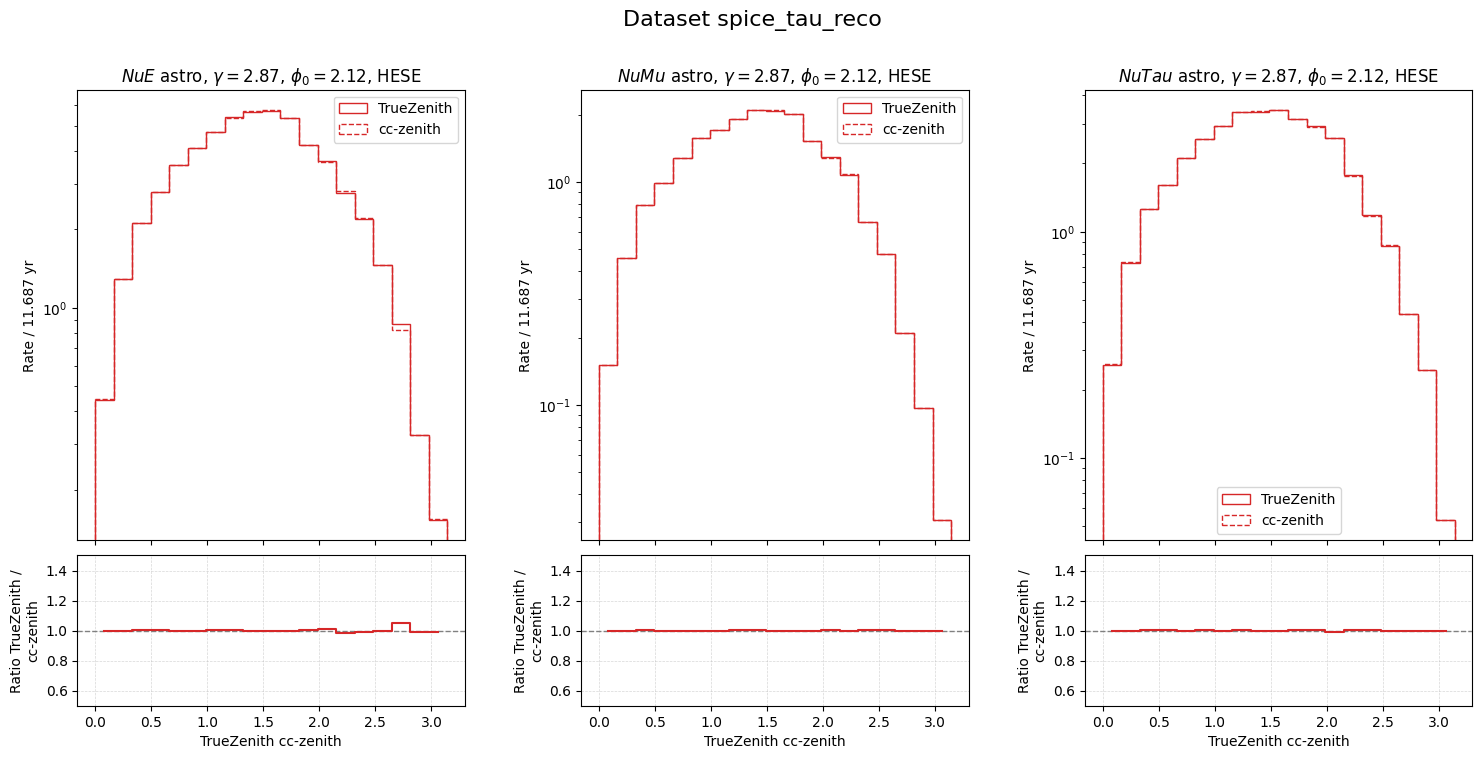

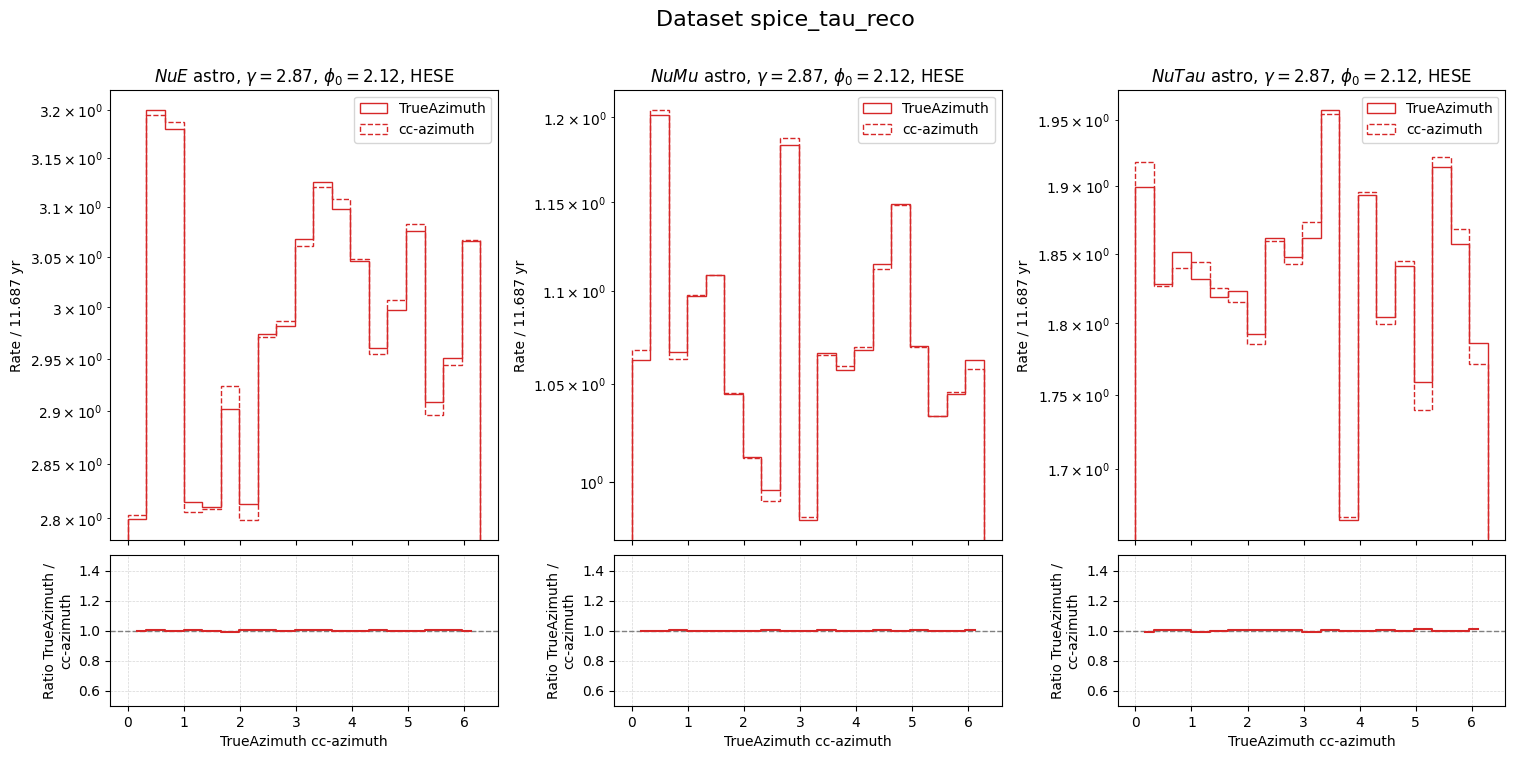

In [16]:
compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueZenith", 
                    var1_key2 = "value",
                    var1_name = "TrueZenith",
                    var2_key1 = "cc", 
                    var2_key2 = "zenith",
                    var2_name = "cc-zenith",
                    bins = np.linspace(0, np.pi, 20),
                    xlabel="TrueZenith cc-zenith",
                    xscale = "linear", yscale = "log",
                    savename = "TrueZenith_vs_cc-zenith.pdf" )

compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueAzimuth", 
                    var1_key2 = "value",
                    var1_name = "TrueAzimuth",
                    var2_key1 = "cc", 
                    var2_key2 = "azimuth",
                    var2_name = "cc-azimuth",
                    bins = np.linspace(0, 2*np.pi, 20),
                    xlabel="TrueAzimuth cc-azimuth",
                    xscale = "linear", yscale = "log",
                    savename = "TrueAzimuth_vs_cc-azimuth.pdf" )

Now the true energy asymmetry. It is very different between Neha's and Tianlu's definition.

Neha
- Takes the MCInteractionDoubleBang cascades and calculates the ratio depending with a E1+E2 threshold of 1 TeV.
- MCInteractionDoubleBang cascade1 is the outgoing hadron, calculating the em-scaled energy
- cascade2 comes from the daughters of the tau lepton.

Tianlu
- Calculates the deposited energy up until the tau decay, and the energy after.

My opinion: Tianlu's implementation is the one that matches better with what Taupede is sensitive to, but I think that Neha's implementation is correct in the actual definition of the energy asymmetry.
I asked tianlu for feedback.

/tmp/ipykernel_14654/4104227861.py:55: RuntimeWarning: divide by zero encountered in divide
  ratio = hist1 / hist2


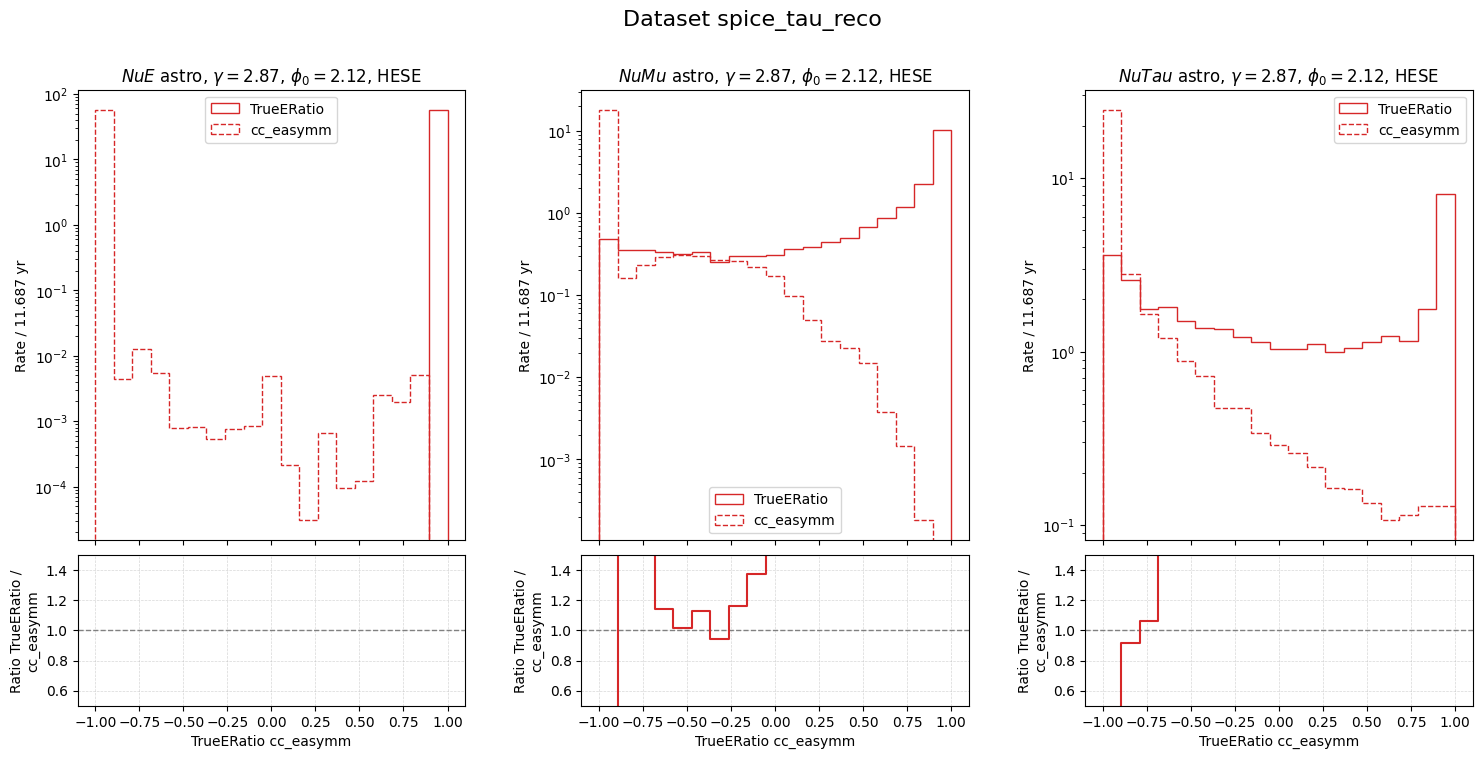

In [18]:
compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueERatio", 
                    var1_key2 = "value",
                    var1_name = "TrueERatio",
                    var2_key1 = "cc_easymm", 
                    var2_key2 = "value",
                    var2_name = "cc_easymm",
                    bins = np.linspace(-1, 1, 20),
                    xlabel="TrueERatio cc_easymm",
                    xscale = "linear", yscale = "log",
                    savename = "TrueERatio_vs_cc_easymm.pdf" )

The length is also very different! I just found out via the performance plots.

Neha
- Puts cascade 1 at the shower max position according to ShowerParameters, same for the tau decay.
- TrueL is simply the distance between these 2 cascades.

Tianlu
- Just takes the length of the tau lepton.

/tmp/ipykernel_14654/4104227861.py:55: RuntimeWarning: invalid value encountered in divide
  ratio = hist1 / hist2
/tmp/ipykernel_14654/4104227861.py:55: RuntimeWarning: divide by zero encountered in divide
  ratio = hist1 / hist2


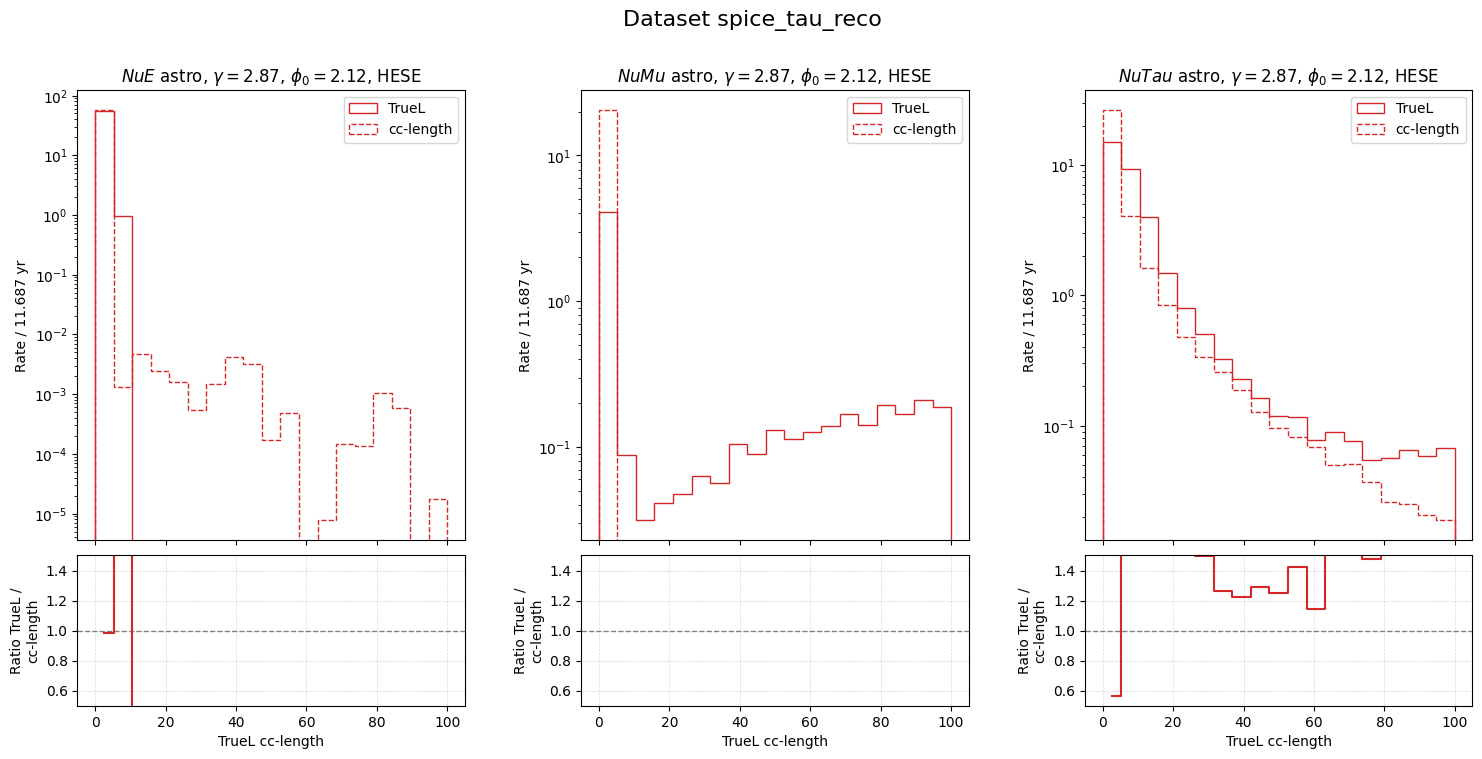

In [19]:
compare_ice_model(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueL", 
                    var1_key2 = "value",
                    var1_name = "TrueL",
                    var2_key1 = "cc", 
                    var2_key2 = "length",
                    var2_name = "cc-length",
                    bins = np.linspace(0, 100, 20),
                    xlabel="TrueL cc-length",
                    xscale = "linear", yscale = "log",
                    savename = "TrueL_vs_cc-length.pdf" )

In [36]:
simulation_datasets["spice_tau_reco"]["NuTau"]["weighter"].get_column("RecoETot", "value")


array([ 189654.14254855,   58455.88260721,  784323.07500033, ...,
       8472155.66526536,  224452.17719296, 6460296.67958436])

Tianlu asked me to add some selections, lets do that

In [16]:
classifications = {}


classifications["cc.length < 5"] = {
    "variables": [("cc", "length")],  # (variable_name, column_type)
    "cut_functions": {
        "All": lambda vars: (vars["cc"] < 5),
    }
}


classifications["5 < cc.length < 20"] = {
    "variables": [("cc", "length")],  # (variable_name, column_type)
    "cut_functions": {
        "All": lambda vars: (vars["cc"] > 5) & (vars["cc"] < 20),
    }
}


classifications["20 < cc.length < 40"] = {
    "variables": [("cc", "length")],  # (variable_name, column_type)
    "cut_functions": {
        "All": lambda vars: (vars["cc"] > 20) & (vars["cc"] < 40),
    }
}

classifications["cc.length > 40"] = {
    "variables": [("cc", "length")],  # (variable_name, column_type)
    "cut_functions": {
        "All": lambda vars: (vars["cc"] > 40),
    }
}

/tmp/ipykernel_54626/944099327.py:63: RuntimeWarning: divide by zero encountered in divide
  ratio = hist1 / hist2


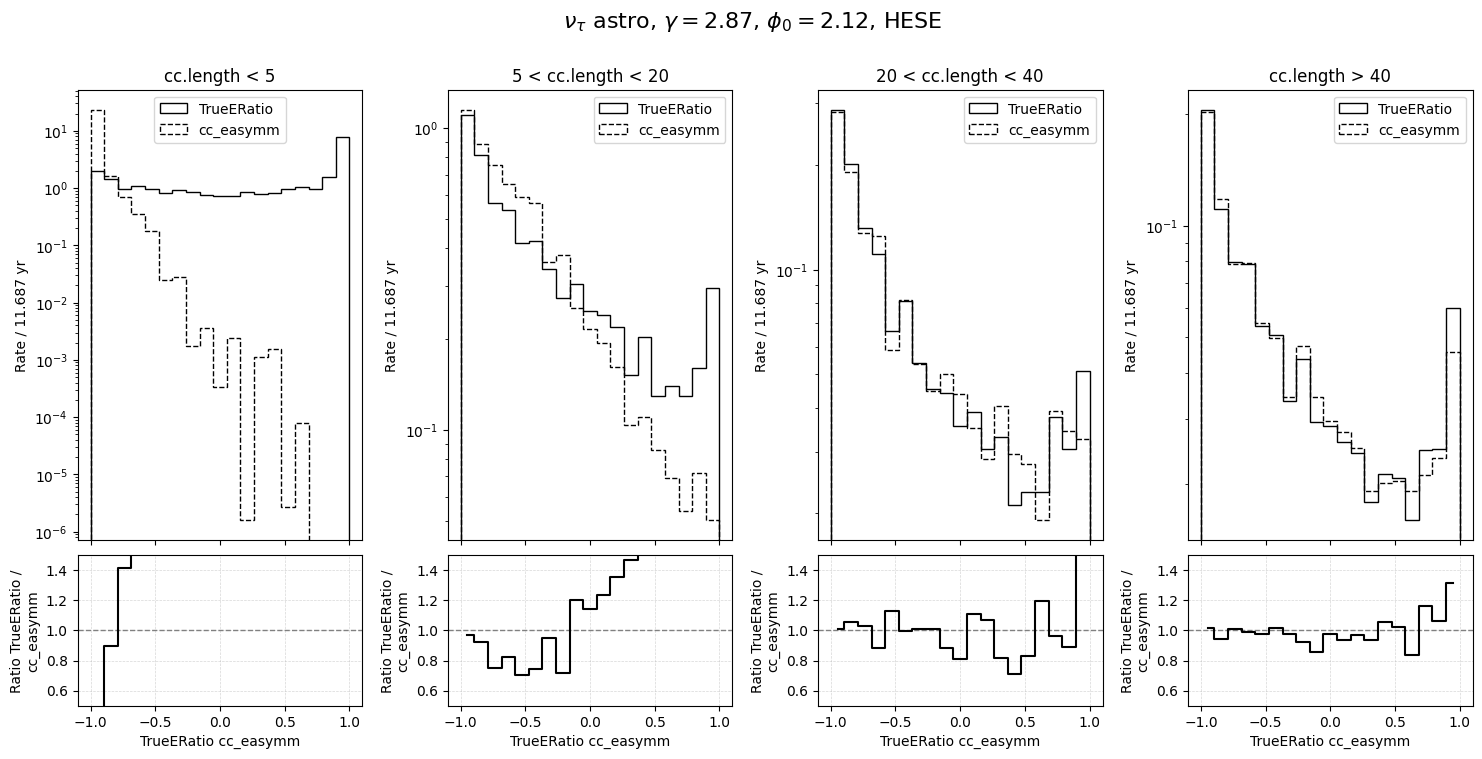

In [17]:
def compare_ice_model_selection( dataset_key = "spice_tau_reco",
                       var1_key1 = "I3MCWeightDict", 
                       var1_key2 = "PrimaryNeutrinoEnergy",
                       var1_name = "PrimaryNeutrinoEnergy",
                       var2_key1 = "I3MCWeightDict", 
                       var2_key2 = "PrimaryNeutrinoEnergy",
                       var2_name = "PrimaryNeutrinoEnergy",
                       classifications = classifications,
                       xlabel    = "PrimaryNeutrinoEnergy [GeV]",
                       bins = np.geomspace(1e4, 1e6, 20),
                       xscale = "log", yscale = "log",
                       savename = "PrimaryNeutrinoEnergy.pdf"):

    color = "black"

    # Compute bin centers for plotting
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Create 2 rows × 3 columns layout: top row = histograms, bottom row = ratios
    fig = plt.figure(figsize=(18, 8))  # Adjust height as needed
    gs = GridSpec(2, 4, height_ratios=[3, 1], hspace=0.05, wspace=0.3)

    fig.suptitle(rf"$\nu_\tau$ astro, $\gamma = 2.87$, $\phi_0=2.12$, HESE", fontsize=16)

    # Create 3 upper and 3 lower subplots
    axes = [fig.add_subplot(gs[0, i]) for i in range(4)]        # ax0, ax1, ax2
    axes_ratio = [fig.add_subplot(gs[1, i], sharex=axes[i]) for i in range(4)]  # ax0_ratio, etc.

    # Now iterate over axes
    for ax, ax_ratio, classification_name in zip(axes, axes_ratio, classifications):
        classification = classifications[classification_name]
        flavor = "NuTau"
        ax.set_title(rf"{classification_name}")
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        ax.set_ylabel(f"Rate / {livetime_yr} yr") 

        ax_ratio.set_xscale(xscale)
        ax_ratio.set_ylabel(f"Ratio {var1_name} /\n{var2_name}")
        ax_ratio.set_xlabel(xlabel)
        ax_ratio.axhline(1, color="gray", linestyle="--", linewidth=1)

        var1 = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var1_key1, var1_key2)
        var2 = simulation_datasets[dataset_key][flavor]["weighter"].get_column(var2_key1, var2_key2)

        classification_variables = {
        var: simulation_datasets[dataset_key][flavor]["weighter"].get_column(var, col_type)
        for var, col_type in classification["variables"]
        }
        
        # Apply the cut function, passing the variables dict
        mask = classification["cut_functions"]["All"](classification_variables)

        var1 = var1[mask]
        var2 = var2[mask]
        weights = simulation_datasets[dataset_key][flavor]["weights_astro"][mask]

        # Compute histograms
        hist1, _  = np.histogram(var1,weights=weights,bins=bins )
        hist2, _  = np.histogram(var2,weights=weights,bins=bins )

        # Compute ratios
        ratio = hist1 / hist2

        ax_ratio.plot(bin_centers, ratio, drawstyle="steps-mid", color=color)

        # Upper plot: histograms
        ax.hist(var1, 
                weights=weights, 
                bins=bins, histtype="step", color=color, linestyle="-",label = var1_name)
        ax.hist(var2, 
                weights=weights, 
                bins=bins, histtype="step", color=color, linestyle="--",label = var2_name)


        # Improve layout
        plt.setp(ax.get_xticklabels(), visible=False)
        ax_ratio.set_ylim(0.5, 1.5)  # adjust as needed
        ax_ratio.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)

        ax.legend()

    plt.savefig(f"{plotting_path}/{savename}")

    plt.show()


# test
compare_ice_model_selection(  dataset_key = "spice_tau_reco",
                    var1_key1 = "TrueERatio", 
                    var1_key2 = "value",
                    var1_name = "TrueERatio",
                    var2_key1 = "cc_easymm", 
                    var2_key2 = "value",
                    var2_name = "cc_easymm",
                    classifications=classifications,
                    bins = np.linspace(-1, 1, 20),
                    xlabel="TrueERatio cc_easymm",
                    xscale = "linear", yscale = "log",
                    savename = "compare_cc_easym_TrueERatio_lengths_tianlu.pdf" )
